In [1]:
import copy
import numpy as np
import pandas as pd
from itertools import product

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm.sklearn import LGBMRegressor
from lightgbm import plot_importance
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_rows', 100)

# GCPAPi指定

In [2]:
from google.cloud import storage
def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket. https://cloud.google.com/storage/docs/ """
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(source_file_name)
    print('File {} uploaded to {}.'.format(
        source_file_name,
        destination_blob_name))

def list_blobs(bucket_name):
    """Lists all the blobs in the bucket. https://cloud.google.com/storage/docs/"""
    blobs = storage_client.list_blobs(bucket_name)
    for blob in blobs:
        print(blob.name)
        

In [3]:
storage_client = storage.Client(project='kaggle-336301')
list_blobs('sokamura_kaggle')

predict_future_sales/
predict_future_sales/input/cats.csv.gz
predict_future_sales/input/item.csv.gz
predict_future_sales/input/shops.csv.gz
predict_future_sales/input/test.csv.gz
predict_future_sales/input/train.csv.gz
predict_future_sales/submission/xgb_submission.csv


# データ概要
## データ読み込み

In [4]:
day_train_data = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
month_test_data = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')
item_categories = pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')
items = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
shops = pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv')

## 生データの閲覧

In [5]:
day_train_data.drop('date', axis=1, inplace=True)

In [6]:
item_categories['item_category_name'].head()

0    PC - Гарнитуры/Наушники
1           Аксессуары - PS2
2           Аксессуары - PS3
3           Аксессуары - PS4
4           Аксессуары - PSP
Name: item_category_name, dtype: object

In [7]:
item_categories['split_name'] = item_categories['item_category_name'].str.split('-')
item_categories['big_category_name'] =\
     item_categories['split_name'].map(lambda x: x[0].strip())
item_categories['sub_category_name'] =\
     item_categories['split_name'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())

item_categories.loc[item_categories['big_category_name'] == 'Чистые носители(штучные)', 'big_category_name'] = 'Чистые носители (шпиль)'

# label encoding
item_categories['big_category_id'] = LabelEncoder().fit_transform(item_categories['big_category_name'])
item_categories['sub_category_id'] = LabelEncoder().fit_transform(item_categories['sub_category_name'])

# データの整理
item_categories = item_categories[['item_category_id', 'big_category_id', 'sub_category_id']]

In [8]:
shops.loc[shops['shop_name'] == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

shops['city_name'] = shops['shop_name'].map(lambda x: x.split(' ')[0])
shops.loc[shops['city_name'] == '!Якутск', 'city_name'] = 'Якутск'

# label encoding
shops['city_id'] = LabelEncoder().fit_transform(shops['city_name'])

# データの整理
shops = shops[['shop_id', 'city_id']]

In [9]:
shops[(shops['shop_id'] == 0) | (shops['shop_id'] == 57)]

,shop_id,city_id
0,0,29
57,57,29


In [10]:
# shop_idの修正
day_train_data.loc[day_train_data['shop_id'] == 0, 'shop_id'] = 57
month_test_data.loc[month_test_data['shop_id'] == 0, 'shop_id'] = 57

day_train_data.loc[day_train_data['shop_id'] == 1, 'shop_id'] = 58
month_test_data.loc[month_test_data['shop_id'] == 1, 'shop_id'] = 58

day_train_data.loc[day_train_data['shop_id'] == 10, 'shop_id'] = 11
month_test_data.loc[month_test_data['shop_id'] == 10, 'shop_id'] = 11

In [11]:
# 外れ値の削除
day_train_data.drop(day_train_data[day_train_data['item_price'] >= 100000].index, inplace=True)
day_train_data.drop(day_train_data[day_train_data['item_cnt_day'] > 1000].index, inplace=True)

# item_priceのエラー値を修正
median = day_train_data[(day_train_data['date_block_num'] == 4) & (day_train_data['shop_id'] == 32) & (day_train_data['item_id'] == 2973) & (day_train_data['item_price'] >= 0)]['item_price'].median()
day_train_data.loc[day_train_data['item_price'] < 0, 'item_price'] = median

In [12]:
# data_setの作成
data_set = []
cols = ['date_block_num', 'shop_id', 'item_id']
for date_num in range(34):
    sales = day_train_data[day_train_data['date_block_num'] == date_num]
    data_set.append(np.array(list(product([date_num],
                                          sales['shop_id'].unique(),
                                          sales['item_id'].unique()))))

data_set = pd.DataFrame(np.vstack(data_set), columns=cols)
data_set.sort_values(cols, inplace=True)
data_set = data_set.reset_index(drop=True)

# month_test_dataのmerge
month_test_data['date_block_num'] = 34
month_test_data['date_block_num'] = month_test_data['date_block_num']
month_test_data['shop_id'] = month_test_data['shop_id']
month_test_data['item_id'] = month_test_data['item_id']

data_set = pd.concat([data_set, month_test_data], ignore_index=True, sort=False, keys=cols)

# data_set = data_set + shops [city_id]
data_set = pd.merge(data_set, shops, on=['shop_id'], how='left')

# data_set = data_set + items [item_category_id]
data_set = pd.merge(data_set, items[['item_id', 'item_category_id']], on=['item_id'], how='left')

# data_set = data_set + item_categories [big_category_id, sub_category_id]
data_set = pd.merge(data_set, item_categories, on=['item_category_id'], how='left')

In [13]:
# item_sales_dayの作成
day_train_data['item_sales_day'] = day_train_data['item_price'] * day_train_data['item_cnt_day']

# item_cnt_monthの作成とmerge
merge_data = day_train_data.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)['item_cnt_day'].agg('sum').rename(columns={'item_cnt_day': 'item_cnt_month'})

data_set = pd.merge(data_set, merge_data, on=cols, how='left')
data_set['item_cnt_month'] = data_set['item_cnt_month'].fillna(0).clip(0, 20)

<AxesSubplot:xlabel='date_block_num', ylabel='item_cnt_month'>

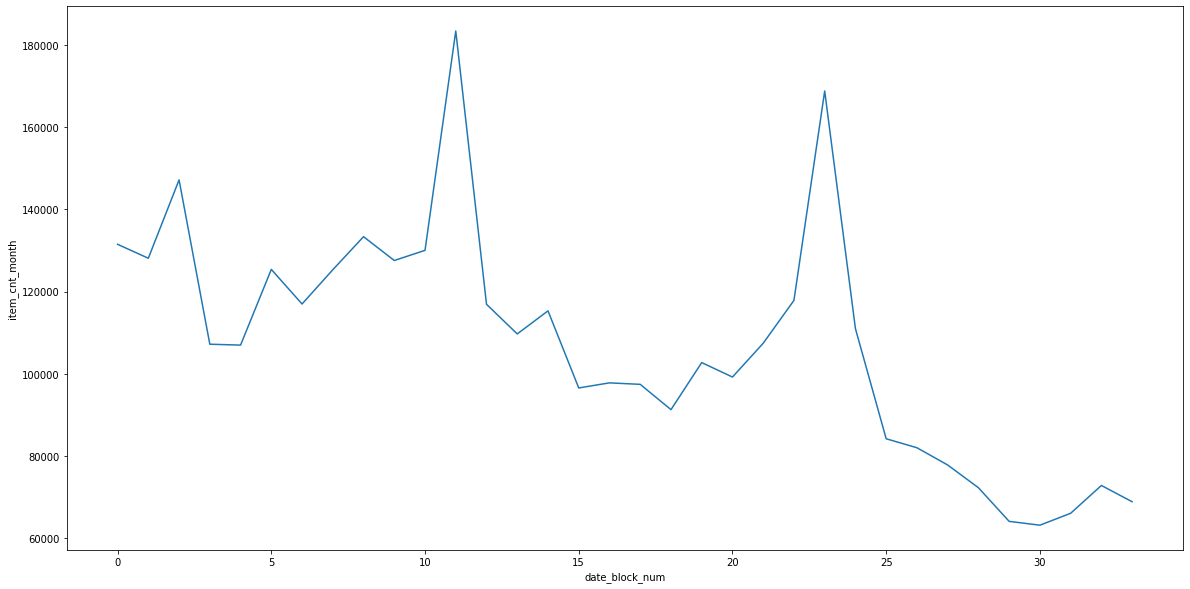

In [14]:
plot_data = day_train_data.groupby(['date_block_num'], as_index=False)['item_cnt_day'].agg('sum').rename(columns={'item_cnt_day': 'item_cnt_month'})

plt.figure(figsize=(20, 10))
sns.lineplot(data=plot_data, x='date_block_num', y='item_cnt_month')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


Text(0.5, 1.0, 'residual')

<Figure size 432x288 with 0 Axes>

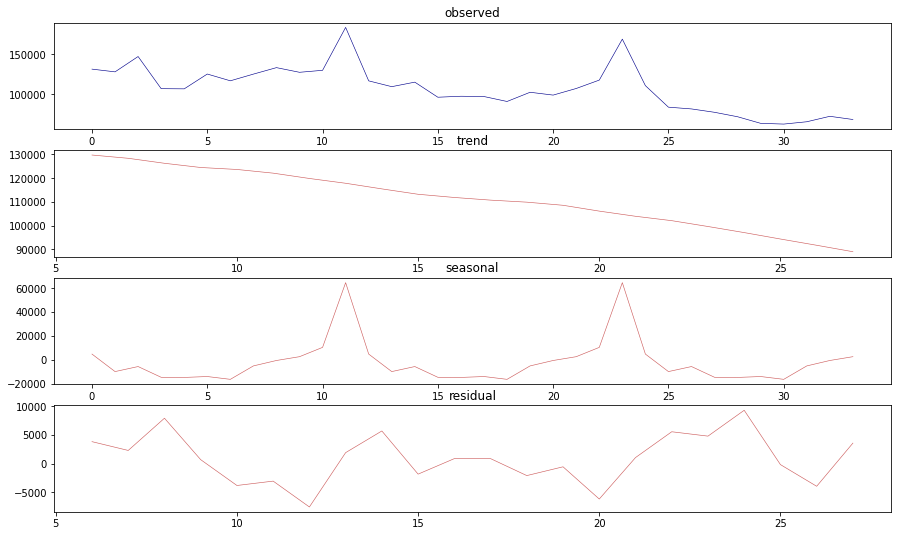

In [15]:
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(plot_data['item_cnt_month'], freq=12)

plt.subplots_adjust(hspace=0.3)
plt.figure(figsize=(15, 9))
plt.subplot(411)
plt.plot(res.observed, lw=.6, c='darkblue')
plt.title('observed')
plt.subplot(412)
plt.plot(res.trend, lw=.6, c='indianred')
plt.title('trend')
plt.subplot(413)
plt.plot(res.seasonal, lw=.6, c='indianred')
plt.title('seasonal')
plt.subplot(414)
plt.plot(res.resid, lw=.6, c='indianred')
plt.title('residual')

In [16]:
data_set.fillna(0, inplace=True)
data_set['date_block_num'] = data_set['date_block_num'].astype(np.uint8)
data_set['shop_id'] = data_set['shop_id'].astype(np.uint8)
data_set['item_id'] = data_set['item_id'].astype(np.uint16)
data_set['item_cnt_month'] = data_set['item_cnt_month'].astype(np.float16)
data_set['ID'] = data_set['ID'].astype(np.uint32)
data_set['city_id'] = data_set['city_id'].astype(np.uint8)
data_set['item_category_id'] = data_set['item_category_id'].astype(np.uint8)
data_set['big_category_id'] = data_set['big_category_id'].astype(np.uint8)
data_set['sub_category_id'] = data_set['sub_category_id'].astype(np.uint8)

In [17]:
def feature_lags(df, lags, lag_col):
    tmp = df[['date_block_num', 'shop_id', 'item_id', lag_col]]
    for lag in lags:
        shifted = tmp.copy()

        shifted.columns = ['date_block_num', 'shop_id', 'item_id', str(lag_col) + '_lag_' + str(lag)]

        shifted['date_block_num'] += lag
        shifted = shifted[shifted['date_block_num'] <= 34]

        df = pd.merge(df, shifted, on=['date_block_num', 'shop_id', 'item_id'], how='left', copy=False)

    return df

In [18]:
#target_lags
data_set = feature_lags(df=data_set, lags=[1, 2, 3, 6, 12], lag_col='item_cnt_month')


# date_avg_item_cnt
date_avg_item_cnt = data_set.groupby(['date_block_num'], as_index=False)['item_cnt_month'].agg('mean').rename(columns={'item_cnt_month': 'date_avg_item_cnt'})

data_set = pd.merge(data_set, date_avg_item_cnt, on=['date_block_num'], how='left')

data_set = feature_lags(df=data_set, lags=[1], lag_col='date_avg_item_cnt')
data_set.drop(['date_avg_item_cnt'], axis=1, inplace=True)


# date_item_avg_item_cnt
date_item_avg_item_cnt = data_set.groupby(['date_block_num', 'item_id'], as_index=False)['item_cnt_month'].agg('mean').rename(columns={'item_cnt_month': 'date_item_avg_item_cnt'})

data_set = pd.merge(data_set, date_item_avg_item_cnt, on=['date_block_num', 'item_id'], how='left')

data_set = feature_lags(df=data_set, lags=[1], lag_col='date_item_avg_item_cnt')
data_set.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)


# date_shop_avg_item_cnt
date_shop_avg_item_cnt = data_set.groupby(['date_block_num', 'shop_id'], as_index=False)['item_cnt_month'].agg('mean').rename(columns={'item_cnt_month': 'date_shop_avg_item_cnt'})

data_set = pd.merge(data_set, date_shop_avg_item_cnt, on=['date_block_num', 'shop_id'], how='left')

data_set = feature_lags(df=data_set, lags=[1], lag_col='date_shop_avg_item_cnt')
data_set.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)


# date_category_avg_item_cnt
date_category_avg_item_cnt = data_set.groupby(['date_block_num', 'item_category_id'], as_index=False)['item_cnt_month'].agg('mean').rename(columns={'item_cnt_month': 'date_category_avg_item_cnt'})

data_set = pd.merge(data_set, date_category_avg_item_cnt, on=['date_block_num', 'item_category_id'], how='left')

data_set = feature_lags(df=data_set, lags=[1], lag_col='date_category_avg_item_cnt')
data_set.drop(['date_category_avg_item_cnt'], axis=1, inplace=True)


# date_shop_category_avg_item_cnt
date_shop_category_avg_item_cnt = data_set.groupby(['date_block_num', 'shop_id', 'item_category_id'], as_index=False)['item_cnt_month'].agg('mean').rename(columns={'item_cnt_month': 'date_shop_category_avg_item_cnt'})

data_set = pd.merge(data_set, date_shop_category_avg_item_cnt, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')

data_set = feature_lags(df=data_set, lags=[1], lag_col='date_shop_category_avg_item_cnt')
data_set.drop(['date_shop_category_avg_item_cnt'], axis=1, inplace=True)


# date_shop_bigcat_avg_item_cnt
date_shop_bigcat_avg_item_cnt = data_set.groupby(['date_block_num', 'shop_id', 'big_category_id'], as_index=False)['item_cnt_month'].agg('mean').rename(columns={'item_cnt_month': 'date_shop_bigcat_avg_item_cnt'})

data_set = pd.merge(data_set, date_shop_bigcat_avg_item_cnt, on=['date_block_num', 'shop_id', 'big_category_id'], how='left')

data_set = feature_lags(df=data_set, lags=[1], lag_col='date_shop_bigcat_avg_item_cnt')
data_set.drop(['date_shop_bigcat_avg_item_cnt'], axis=1, inplace=True)


# date_shop_subcat_avg_item_cnt
date_shop_subcat_avg_item_cnt = data_set.groupby(['date_block_num', 'shop_id', 'sub_category_id'], as_index=False)['item_cnt_month'].agg('mean').rename(columns={'item_cnt_month': 'date_shop_subcat_avg_item_cnt'})

data_set = pd.merge(data_set, date_shop_subcat_avg_item_cnt, on=['date_block_num', 'shop_id', 'sub_category_id'], how='left')

data_set = feature_lags(df=data_set, lags=[1], lag_col='date_shop_subcat_avg_item_cnt')
data_set.drop(['date_shop_subcat_avg_item_cnt'], axis=1, inplace=True)


# date_bigcat_avg_item_cnt
date_bigcat_avg_item_cnt = data_set.groupby(['date_block_num', 'big_category_id'], as_index=False)['item_cnt_month'].agg('mean').rename(columns={'item_cnt_month': 'date_bigcat_avg_item_cnt'})

data_set = pd.merge(data_set, date_bigcat_avg_item_cnt, on=['date_block_num', 'big_category_id'], how='left')

data_set = feature_lags(df=data_set, lags=[1], lag_col='date_bigcat_avg_item_cnt')
data_set.drop(['date_bigcat_avg_item_cnt'], axis=1, inplace=True)


# date_subcat_avg_item_cnt
date_subcat_avg_item_cnt = data_set.groupby(['date_block_num', 'sub_category_id'], as_index=False)['item_cnt_month'].agg('mean').rename(columns={'item_cnt_month': 'date_subcat_avg_item_cnt'})

data_set = pd.merge(data_set, date_subcat_avg_item_cnt, on=['date_block_num', 'sub_category_id'], how='left')

data_set = feature_lags(df=data_set, lags=[1], lag_col='date_subcat_avg_item_cnt')
data_set.drop(['date_subcat_avg_item_cnt'], axis=1, inplace=True)


# date_city_avg_item_cnt
date_city_avg_item_cnt = data_set.groupby(['date_block_num', 'city_id'], as_index=False)['item_cnt_month'].agg('mean').rename(columns={'item_cnt_month': 'date_city_avg_item_cnt'})

data_set = pd.merge(data_set, date_city_avg_item_cnt, on=['date_block_num', 'city_id'], how='left')

data_set = feature_lags(df=data_set, lags=[1], lag_col='date_city_avg_item_cnt')
data_set.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)


# date_item_city_avg_item_cnt
date_item_city_avg_item_cnt = data_set.groupby(['date_block_num', 'item_id', 'city_id'], as_index=False)['item_cnt_month'].agg('mean').rename(columns={'item_cnt_month': 'date_item_city_avg_item_cnt'})

data_set = pd.merge(data_set, date_item_city_avg_item_cnt, on=['date_block_num', 'item_id', 'city_id'], how='left')

data_set = feature_lags(df=data_set, lags=[1], lag_col='date_item_city_avg_item_cnt')
data_set.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

In [19]:
# item_avg_item_price
item_avg_item_price = day_train_data.groupby(['item_id'], as_index=False)['item_price'].agg('mean').rename(columns={'item_price': 'item_avg_item_price'})

data_set = pd.merge(data_set, item_avg_item_price, on=['item_id'], how='left')


# date_item_avg_item_price
date_item_avg_item_price = day_train_data.groupby(['date_block_num', 'item_id'], as_index=False)['item_price'].agg('mean').rename(columns={'item_price': 'date_item_avg_item_price'})

data_set = pd.merge(data_set, date_item_avg_item_price, on=['date_block_num', 'item_id'], how='left')


lags = [1, 2, 3, 4, 5, 6]
data_set = feature_lags(df=data_set, lags=lags, lag_col='date_item_avg_item_price')

for lag in lags:
    data_set['delta_price_lag_' + str(lag)]  = (data_set['date_item_avg_item_price_lag_' + str(lag)] - data_set['item_avg_item_price'] / data_set['item_avg_item_price'])

def select_trend(row):
    for lag in lags:
        if row['delta_price_lag_' + str(lag)]:
            return row['delta_price_lag_' + str(lag)]
    return 0    

data_set['delta_price_lag'] = data_set.apply(select_trend, axis=1)
data_set['delta_price_lag'].fillna(0, inplace=True)


# 使わないデータの削除
features_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for lag in lags:
    features_to_drop += ['date_item_avg_item_price_lag_' + str(lag)]
    features_to_drop += ['delta_price_lag_' + str(lag)]

data_set.drop(features_to_drop, axis=1, inplace=True)

In [20]:
date_shop_sales = day_train_data.groupby(['date_block_num', 'shop_id'], as_index=False)['item_sales_day'].agg('sum').rename(columns={'item_sales_day': 'date_shop_sales'})

data_set = pd.merge(data_set, date_shop_sales, on=['date_block_num', 'shop_id'], how='left')

shop_avg_sales = day_train_data.groupby(['shop_id'], as_index=False)['item_sales_day'].agg('mean').rename(columns={'item_sales_day': 'shop_avg_sales'})

data_set = pd.merge(data_set, shop_avg_sales, on=['shop_id'], how='left')

data_set['delta_sales'] = (data_set['date_shop_sales'] - data_set['shop_avg_sales']) / data_set['shop_avg_sales']
data_set = feature_lags(df=data_set, lags=[1], lag_col='delta_sales')
data_set.drop(['date_shop_sales', 'shop_avg_sales', 'delta_sales'], axis=1, inplace=True)

In [21]:
data_set['month'] = data_set['date_block_num'] % 12

days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
data_set['day'] = data_set['month'].map(days)
data_set['day'] = data_set['day'].astype(np.uint8)

In [22]:
data_set.fillna(0, inplace=True)

In [23]:
data_set.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 29 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   date_block_num                         uint8  
 1   shop_id                                uint8  
 2   item_id                                uint16 
 3   ID                                     uint32 
 4   city_id                                uint8  
 5   item_category_id                       uint8  
 6   big_category_id                        uint8  
 7   sub_category_id                        uint8  
 8   item_cnt_month                         float16
 9   item_cnt_month_lag_1                   float16
 10  item_cnt_month_lag_2                   float16
 11  item_cnt_month_lag_3                   float16
 12  item_cnt_month_lag_6                   float16
 13  item_cnt_month_lag_12                  float16
 14  date_avg_item_cnt_lag_1                float16
 

In [24]:
target_col = 'item_cnt_month'
exclude_cols = ['ID', target_col]

feature_cols = []
for col in data_set.columns:
    if col not in exclude_cols:
        feature_cols.append(col)

x_train = data_set[data_set['date_block_num'] <= 32][feature_cols]
y_train = data_set[data_set['date_block_num'] <= 32][target_col]
x_val = data_set[data_set['date_block_num'] == 33][feature_cols]
y_val = data_set[data_set['date_block_num'] == 33][target_col]
x_test = data_set[feature_cols]

In [25]:

gbm = LGBMRegressor(n_jobs=-1)
gbm.fit(x_train, y_train,
       eval_metric='rmse',
       eval_set=(x_val, y_val))

# rmse: 0.948226


[1]	valid_0's rmse: 1.10295	valid_0's l2: 1.21651
[2]	valid_0's rmse: 1.07663	valid_0's l2: 1.15914
[3]	valid_0's rmse: 1.05338	valid_0's l2: 1.10961
[4]	valid_0's rmse: 1.03404	valid_0's l2: 1.06924
[5]	valid_0's rmse: 1.02067	valid_0's l2: 1.04177
[6]	valid_0's rmse: 1.00835	valid_0's l2: 1.01677
[7]	valid_0's rmse: 0.998716	valid_0's l2: 0.997434
[8]	valid_0's rmse: 0.990723	valid_0's l2: 0.981532
[9]	valid_0's rmse: 0.983937	valid_0's l2: 0.968132
[10]	valid_0's rmse: 0.978742	valid_0's l2: 0.957937
[11]	valid_0's rmse: 0.974427	valid_0's l2: 0.949509
[12]	valid_0's rmse: 0.970672	valid_0's l2: 0.942204
[13]	valid_0's rmse: 0.96759	valid_0's l2: 0.936231
[14]	valid_0's rmse: 0.964357	valid_0's l2: 0.929984
[15]	valid_0's rmse: 0.962204	valid_0's l2: 0.925836
[16]	valid_0's rmse: 0.960426	valid_0's l2: 0.922418
[17]	valid_0's rmse: 0.958709	valid_0's l2: 0.919122
[18]	valid_0's rmse: 0.957247	valid_0's l2: 0.916322
[19]	valid_0's rmse: 0.95599	valid_0's l2: 0.913917
[20]	valid_0's r

LGBMRegressor()

In [26]:
gbm = LGBMRegressor(n_estimators=10000, max_depth=10, n_jobs=-1)
gbm.fit(x_train, y_train,
        early_stopping_rounds=20,
        eval_metric='rmse',
        eval_set=(x_val, y_val),
        verbose=1)

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's rmse: 1.10295	valid_0's l2: 1.21651
[2]	valid_0's rmse: 1.07663	valid_0's l2: 1.15914
[3]	valid_0's rmse: 1.05338	valid_0's l2: 1.10961
[4]	valid_0's rmse: 1.03404	valid_0's l2: 1.06924
[5]	valid_0's rmse: 1.02067	valid_0's l2: 1.04177
[6]	valid_0's rmse: 1.00824	valid_0's l2: 1.01654
[7]	valid_0's rmse: 0.997778	valid_0's l2: 0.995562
[8]	valid_0's rmse: 0.989697	valid_0's l2: 0.979499
[9]	valid_0's rmse: 0.982925	valid_0's l2: 0.966141
[10]	valid_0's rmse: 0.976971	valid_0's l2: 0.954473
[11]	valid_0's rmse: 0.972651	valid_0's l2: 0.94605
[12]	valid_0's rmse: 0.968837	valid_0's l2: 0.938644
[13]	valid_0's rmse: 0.966244	valid_0's l2: 0.933628
[14]	valid_0's rmse: 0.964048	valid_0's l2: 0.929388
[15]	valid_0's rmse: 0.961908	valid_0's l2: 0.925267
[16]	valid_0's rmse: 0.960008	valid_0's l2: 0.921616
[17]	valid_0's rmse: 0.958874	valid_0's l2: 0.919439
[18]	valid_0's rmse: 0.9574	valid_0's l2: 0.916614
[19]	valid_0's rmse: 0.955958	valid_0's l2: 0.913856
[20]	valid_0's rm

LGBMRegressor(max_depth=10, n_estimators=10000)